In [2]:
# Common imports
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [4]:
##########  Using gym
import gym

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# LunarLander-v2 environment
env = gym.make("LunarLander-v2", render_mode='rgb_array')

In [7]:
#The inputs are 8-dimensional:
env.observation_space

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

In [9]:
#env.seed(42)
obs = env.reset()
obs

(array([-0.0070158 ,  1.4045768 , -0.7106382 , -0.28194338,  0.00813633,
         0.1609701 ,  0.        ,  0.        ], dtype=float32),
 {})

From the source code, we can see that these each 8D observation (x, y, h, v, a, w, l, r) correspond to:

x,y: the coordinates of the spaceship. It starts at a random location near (0, 1.4) and must land near the target at (0, 0).
h,v: the horizontal and vertical speed of the spaceship. It starts with a small random speed.
a,w: the spaceship's angle and angular velocity.
l,r: whether the left or right leg touches the ground (1.0) or not (0.0).

In [10]:
# The action space is discrete, with 4 possible actions:
env.action_space


Discrete(4)

Discrete(4)
Looking at the LunarLander-v2's description, these actions are:

do nothing
fire left orientation engine
fire main engine
fire right orientation engine

In [11]:
# Let's create a simple policy network with 4 output neurons (one per possible action):
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(n_outputs, activation="softmax"),
])

In [18]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, tr,info = env.step(action[0, 0].numpy())
    return obs, reward, done, grads

def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        obs=obs[0]
        for step in range(n_max_steps):
            obs, reward, done, grads = lander_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [19]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [20]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = 0.99

In [21]:
# Since the model is a multiclass classification model, we must use the categorical cross-entropy rather than the 
# binary cross-entropy. Moreover, since the lander_play_one_step() function sets the targets as class indices rather 
#than class probabilities, we must use the sparse_categorical_crossentropy() loss function:

optimizer = keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = keras.losses.sparse_categorical_crossentropy

In [ ]:
#env.seed(42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print("\rIteration: {}/{}, mean reward: {:.1f}  ".format(
        iteration + 1, n_iterations, mean_reward), end="")
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 85/200, mean reward: 8.1     

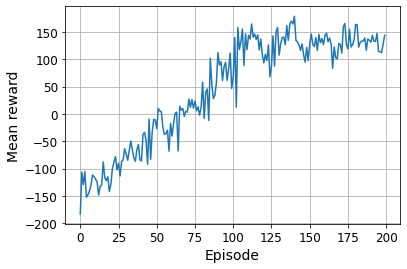

In [14]:
import matplotlib.pyplot as plt

plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.grid()
plt.show()

In [15]:
def lander_render_policy_net(model, n_max_steps=500, seed=42):
    frames = []
    env = gym.make("LunarLander-v2")
    env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

In [17]:
# Now show the animation:

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [18]:
frames = lander_render_policy_net(model, seed=42)
plot_animation(frames)